In [1]:
# import libs
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data

**Fundamental Energy Data (Provided)**

*Recent and Historic Energy Statistics*

- Energy Data - Consumption.csv

- Energy Data - Imports & Exports.csv

- Energy Data - Production.csv

- Energy Data - Stocks.csv

<br>

**Market Data**

*Futures Curves (From Refinitiv)*

- wti_futures_curve_clean.csv

- hh_nat_gas_futures_curve.csv

*Futures Trading Volume (From Refinitiv)*

- wti_futures_continuous_volume.csv

- hh_nat_gas_futures_volume_.csv

*1 Month Implied Volatility (From Refinitiv)*

- wti_continuous_options_deltas.csv
    
- wti_continuous_options_moneyness.csv

- hh_nat_gas_continuous_options_deltas.csv

- hh_nat_gas_continuous_options_moneyness.csv

*Energy Sector Stocks and Commodities (HLOC) (Provided)*

- all_commodities.csv

- all_stocks_and_etfs.csv

- stock_descriptions.csv


## Fundamental Energy Data

In [2]:
# Define paths

fundamental_data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data" 

consumption = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Consumption.csv'))

imports_exports = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Imports & Exports.csv'))

production = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Production.csv'))

stocks = pd.read_csv(os.path.join(fundamental_data_folderpath, 'Energy Data - Stocks.csv'))


### EDA on Fundamental Energy Data

**Note:**

For consumption data, we are using the series 'Natural Gas Consumption, Total' to represent natural gas consumption, and a weighted average of 

['Total Petroleum Consumed by the Residential Sector',
       'Total Petroleum Consumed by the Commercial Sector',
       'Total Hydrocarbon Gas Liquids Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Transportation Sector',
       'Total Petroleum Consumed by the Electric Power Sector']

to represent total petroleum consumption.

In [3]:
consumption.head()

,EIA_ID,YYYYMM,Date,Value,Column_Order,Description,Unit,Energy Type,Energy Category,Energy Class,Sector
0,DFRCPUS,197301,1/1/1973,1706.943,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
1,DFRCPUS,197302,2/1/1973,1614.436,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
2,DFRCPUS,197303,3/1/1973,1140.521,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
3,DFRCPUS,197304,4/1/1973,824.604,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential
4,DFRCPUS,197305,5/1/1973,676.745,1,Distillate Fuel Oil Consumed by the Residentia...,Thousand Barrels per Day,Distillate Fuel Oil,Distillate Fuel Oil,Petroleum,Residential


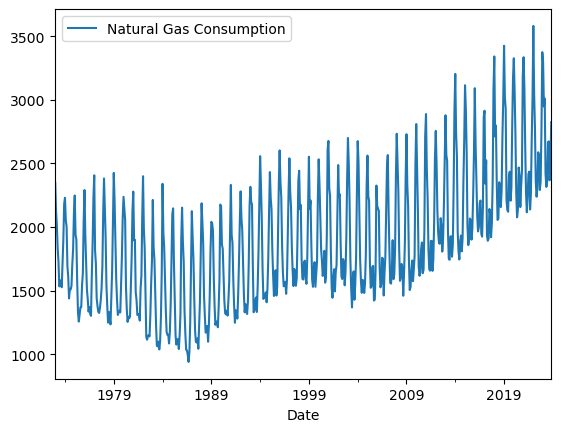

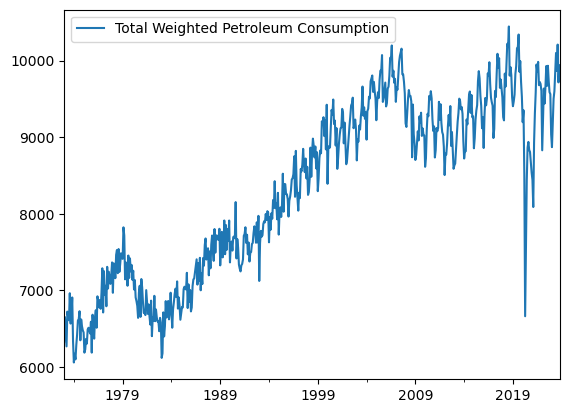

In [4]:
# # EDA for consumption data

# print(consumption['Description'].unique())
# print(consumption['Energy Category'].unique())
# print(consumption['Energy Class'].unique())

# Convert 'Date' to datetime
consumption['Date'] = pd.to_datetime(consumption['Date'])

# Create a dict of dicts of dfs for the Petroleum and Natural Gas Categories
consumption_dict = {}
petroleum_df = consumption[consumption['Energy Class'] == 'Petroleum']
natural_gas_df = consumption[consumption['Energy Class'] == 'Natural Gas']

#Print all 'Description' values in both dfs where the word 'Total' is present
petroleum_df[petroleum_df['Description'].str.contains('Total')]['Description'].unique()

natural_gas_df[natural_gas_df['Description'].str.contains('Total')]['Description'].unique()

# To keep: 
petroleum_series_to_keep = ['Total Petroleum Consumed by the Residential Sector',
       'Total Petroleum Consumed by the Commercial Sector',
       'Total Hydrocarbon Gas Liquids Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Industrial Sector',
       'Total Petroleum Consumed by the Transportation Sector',
       'Total Petroleum Consumed by the Electric Power Sector']

natural_gas_series_to_keep = ['Natural Gas Consumption, Total']

# Subset petroleum and natural gas dfs to only keep the series we want
petroleum_df = petroleum_df[petroleum_df['Description'].isin(petroleum_series_to_keep)]
natural_gas_df = natural_gas_df[natural_gas_df['Description'].isin(natural_gas_series_to_keep)]


# Convert the 'Value' column to float for both petroleum_df and natural_gas_df
petroleum_df['Value'] = pd.to_numeric(petroleum_df['Value'].str.replace(',', ''), errors='coerce')
natural_gas_df['Value'] = pd.to_numeric(natural_gas_df['Value'].str.replace(',', ''), errors='coerce')

# # Use groupby to find the weight of each EIA_ID in the petroleum and natural gas classes by taking the sum of the 'Value' column and dividing by the sum of the 'Value' column for all EIA_IDs in the class
# petroleum_df.groupby('EIA_ID').sum()['Value'] 
grouped_values = petroleum_df.groupby('EIA_ID')['Value'].sum() # This is ok because all units are the same
total_value = grouped_values.sum()

petroleum_weights = grouped_values / total_value

petro_dict = {}

# Extract the individual series identified by their EIA_IDs from petroleum_df 
for eia_id in petroleum_df['EIA_ID'].unique():
    petro_dict[eia_id] = petroleum_df[petroleum_df['EIA_ID'] == eia_id]


# Validate the dict structure and endpoint dfs
petro_dict[list(petro_dict.keys())[5]]




# # # Use petroleum weights to create a new df with the weighted values over time
petroleum_weighted_df = pd.DataFrame()
petroleum_weighted_df.index = petroleum_df['Date'].unique()
for eia_id in petro_dict.keys():
    petroleum_weighted_df[eia_id] = petro_dict[eia_id].groupby('Date')['Value'].sum() * petroleum_weights[eia_id]

petroleum_weighted_df['Total Weighted Petroleum Consumption'] = petroleum_weighted_df.sum(axis=1)
petroleum_weighted_df

natural_gas_df

# # Define petroleum_weighted_consumption as a series equal to the 'Total Weighted Petroleum Consumption' column of petroleum_weighted_df
petroleum_weighted_consumption = petroleum_weighted_df['Total Weighted Petroleum Consumption']
# # Define natural_gas_consumption as a series equal to the 'Value' column of natural_gas_df
natural_gas_consumption = natural_gas_df['Value']
natural_gas_consumption.index = natural_gas_df['Date']

# Remove the first 24 rows of natural_gas_consumption, which report annualized rather than monthly values
natural_gas_consumption = natural_gas_consumption[24:]

# Each year reports 12 monthly values and an annual value. Therefore, for any duplicate indices left in the series, drop the row with the annual value by seleting the 2nd duplicate
natural_gas_consumption = natural_gas_consumption[~natural_gas_consumption.index.duplicated(keep='last')]


#Examine both series
petroleum_weighted_consumption.describe()
natural_gas_consumption.describe()

# Rename the values in the natural_gas_consumption series to 'Natural Gas Consumption'
natural_gas_consumption.name = 'Natural Gas Consumption'

natural_gas_consumption.plot()
plt.legend()
plt.show()
petroleum_weighted_consumption.plot()
plt.legend()
plt.show()


### De-Trending and De-Seasonalizing Consumption

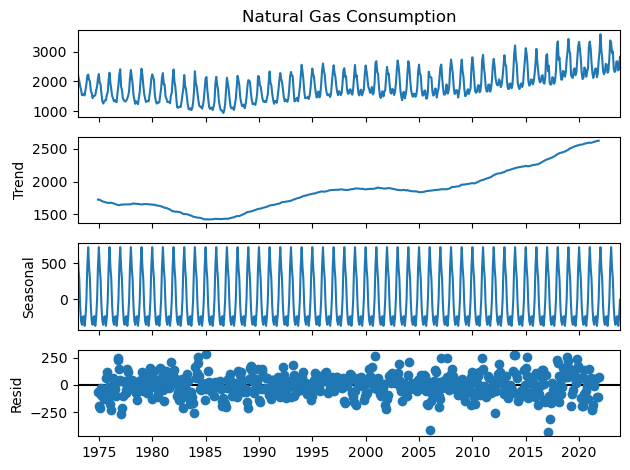

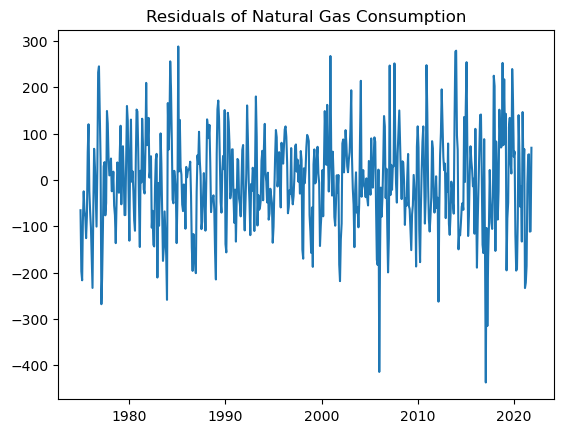

Natural Gas Consumption ADF Statistic: 1.2480552167341192
Natural Gas Consumption ADF p-value: 0.9963016494281062


In [5]:
# De-Trend / De-Seasonalize Natural Gas Consumption

import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit


###
# Try seasonal decomposition on the original natural gas consumption series
n = 48
filt = np.ones(n) / n
natural_gas_decomposition = seasonal_decompose(natural_gas_consumption, model='additive', filt=filt, period=12)

# plot the components
natural_gas_decomposition.plot()
plt.show()


# Plot residuals
plt.plot(natural_gas_decomposition.resid)
plt.title('Residuals of Natural Gas Consumption')
plt.show()

# Stationarity test
from statsmodels.tsa.stattools import adfuller

natural_gas_adf = adfuller(natural_gas_consumption)
print('Natural Gas Consumption ADF Statistic:', natural_gas_adf[0])
print('Natural Gas Consumption ADF p-value:', natural_gas_adf[1])

# Write to cleaned dataset:
    # natural gas consumption
    # trend
    # seasonal
    # residual

# create a folder to store the cleaned data
if not os.path.exists("data\cleaned_data"):
    os.makedirs("data\cleaned_data")

if not os.path.exists("data\cleaned_data\consumption_production"):
    os.makedirs("data\cleaned_data\consumption_production")

write_path = "data\cleaned_data\consumption_production"

df = pd.DataFrame()
df['Date'] = natural_gas_consumption.index
df['Natural Gas Consumption'] = natural_gas_consumption.values
df['Trend'] = natural_gas_decomposition.trend.values
df['Seasonal'] = natural_gas_decomposition.seasonal.values
df['Residual'] = natural_gas_decomposition.resid.values
df.to_csv(os.path.join(write_path, 'natural_gas_consumption_deseasonalized.csv'), index=False)



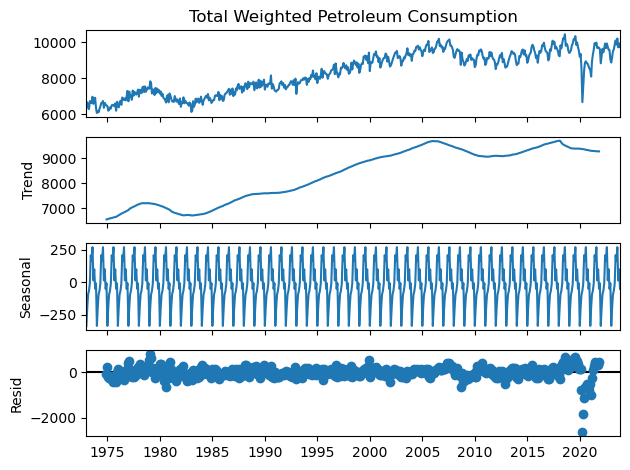

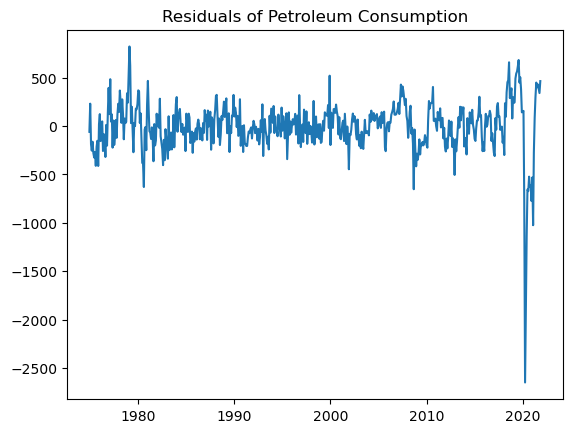

Petroleum Consumption ADF Statistic: -1.2378262702746838
Petroleum Consumption ADF p-value: 0.6571159120742556


In [6]:
# Try seasonal decomposition on the original petroleum consumption series

n = 48
filt = np.ones(n) / n
petroleum_decomposition = seasonal_decompose(petroleum_weighted_consumption, model='additive', filt=filt, period=12)

# plot the components
petroleum_decomposition.plot()
plt.show()

# Plot residuals
plt.plot(petroleum_decomposition.resid)
plt.title('Residuals of Petroleum Consumption')
plt.show()

# Stationarity test
petroleum_adf = adfuller(petroleum_weighted_consumption)
print('Petroleum Consumption ADF Statistic:', petroleum_adf[0])
print('Petroleum Consumption ADF p-value:', petroleum_adf[1])

# Write to cleaned dataset:
    # petroleum consumption
    # trend
    # seasonal
    # residual

df = pd.DataFrame()
df['Date'] = petroleum_weighted_consumption.index
df['Petroleum Consumption'] = petroleum_weighted_consumption.values
df['Trend'] = petroleum_decomposition.trend.values
df['Seasonal'] = petroleum_decomposition.seasonal.values
df['Residual'] = petroleum_decomposition.resid.values
df.to_csv(os.path.join(write_path, 'petroleum_consumption_deseasonalized.csv'), index=False)



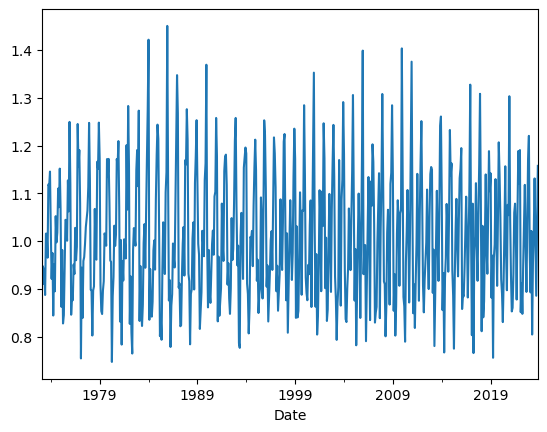

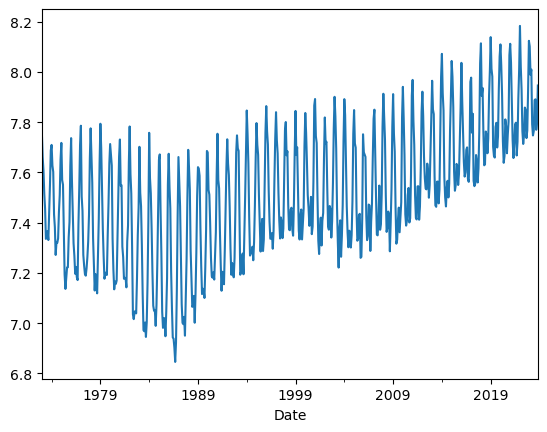

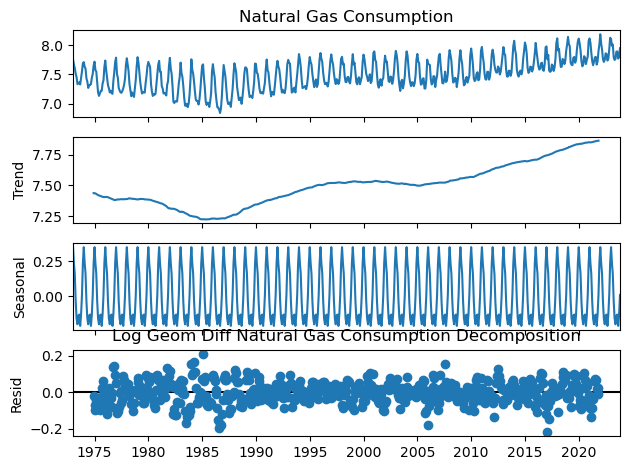

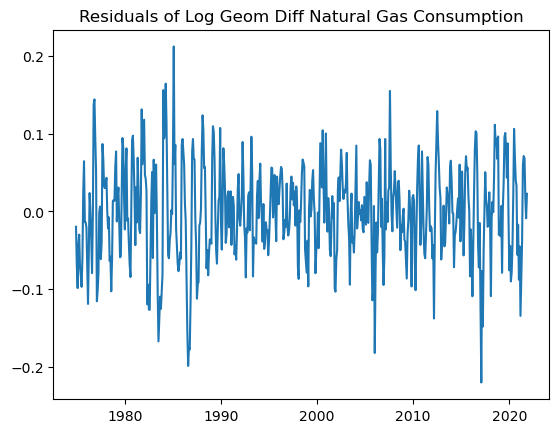

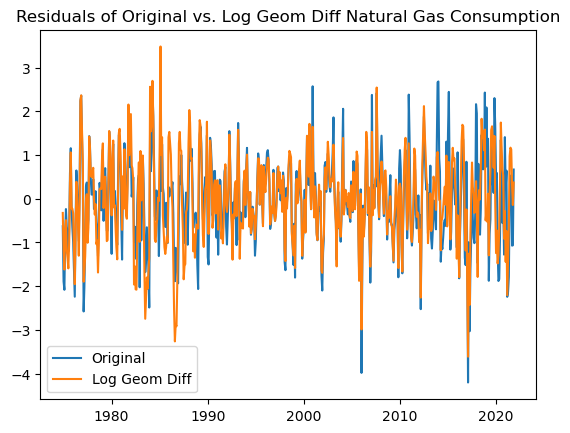

In [7]:
# Try working with geometric change in production rather than outright level

geom_diff_natural_gas_consumption = natural_gas_consumption / natural_gas_consumption.shift(1)
geom_diff_natural_gas_consumption = geom_diff_natural_gas_consumption[1:]
geom_diff_natural_gas_consumption.plot()
plt.show()

# take log
log_natural_gas_consumption = np.log(natural_gas_consumption)
log_natural_gas_consumption.plot()
plt.show()

# run seasonal decomposition on log geom diff
n = 48
filt = np.ones(n) / n
log_natural_gas_decomposition = seasonal_decompose(log_natural_gas_consumption, model='additive', filt=filt, period=12)
log_natural_gas_decomposition.plot()
plt.title('Log Geom Diff Natural Gas Consumption Decomposition')
plt.show()

# Plot residuals
plt.plot(log_natural_gas_decomposition.resid)
plt.title('Residuals of Log Geom Diff Natural Gas Consumption')
plt.show()


# Overlay vs. plot of residuals of original natural gas consumption
    # First rescale to normalize both series
plt.plot(natural_gas_decomposition.resid / natural_gas_decomposition.resid.std())
plt.plot(log_natural_gas_decomposition.resid / log_natural_gas_decomposition.resid.std())
plt.title('Residuals of Original vs. Log Geom Diff Natural Gas Consumption')
plt.legend(['Original', 'Log Geom Diff'])
plt.show()



### EDA on Production

**Note:**
Use 'Natural Gas (Dry) Production' and 'Crude Oil Production' to represent the nat gas and crude oil production series, respectively

In [8]:
production['Unit'].unique()


# if any 'Quadrillion Btu' in 'Unit' col, run the below code
if 'Quadrillion Btu' in production['Unit'].unique():
    # If the 'Unit' col has value 'Quadrillion Btu', convert to 'Trillion Btu' and multiply the 'Value' col by 1000
    production['Value'] = np.where(production['Unit'] == 'Quadrillion Btu', production['Value'] * 1000, production['Value'])

# production[production['Description'] == 'Crude Oil Production']

production


,EIA_ID,YYYYMM,Date,Value,Column_Order,Description,Unit
0,WDPRBUS,197301,1/1/1973,129.63,1,Wood Energy Production,Trillion Btu
1,WDPRBUS,197302,2/1/1973,117.194,1,Wood Energy Production,Trillion Btu
2,WDPRBUS,197303,3/1/1973,129.763,1,Wood Energy Production,Trillion Btu
3,WDPRBUS,197304,4/1/1973,125.462,1,Wood Energy Production,Trillion Btu
4,WDPRBUS,197305,5/1/1973,129.624,1,Wood Energy Production,Trillion Btu
...,...,...,...,...,...,...,...
10382,TEPRBUS,202307,7/1/2023,8.6988278.6988278.6988278.6988278.6988278.6988...,13,Total Primary Energy Production,Quadrillion Btu
10383,TEPRBUS,202308,8/1/2023,8.8459068.8459068.8459068.8459068.8459068.8459...,13,Total Primary Energy Production,Quadrillion Btu
10384,TEPRBUS,202309,9/1/2023,8.5652668.5652668.5652668.5652668.5652668.5652...,13,Total Primary Energy Production,Quadrillion Btu
10385,TEPRBUS,202310,10/1/2023,8.7674268.7674268.7674268.7674268.7674268.7674...,13,Total Primary Energy Production,Quadrillion Btu


In [9]:
# Converting 'Value' col to numeric
def extract_float(x):

    # If '.' appears more than once in the string
    if x.count('.') > 1:
        # Ex: 1.21773.21773.21773.21773.21773
        # Extract the first float (stop at second '.')
        return float(x[:x.find('.', x.find('.') + 1)])
    else:
        # use pd.to_numeric to convert the string to float
        return pd.to_numeric(x, errors='coerce')
    
# Test the function
print(extract_float('1.21773.21773.21773.21773.21773'), extract_float('1.21773'))

1.21773 1.21773


EIA_ID <class 'str'>
YYYYMM <class 'numpy.int64'>
Date <class 'str'>
Value <class 'str'>
Column_Order <class 'numpy.int64'>
Description <class 'str'>
Unit <class 'str'>
['Natural Gas (Dry) Production' 'Crude Oil Production'
 'Natural Gas Plant Liquids Production' 'Total Fossil Fuels Production']


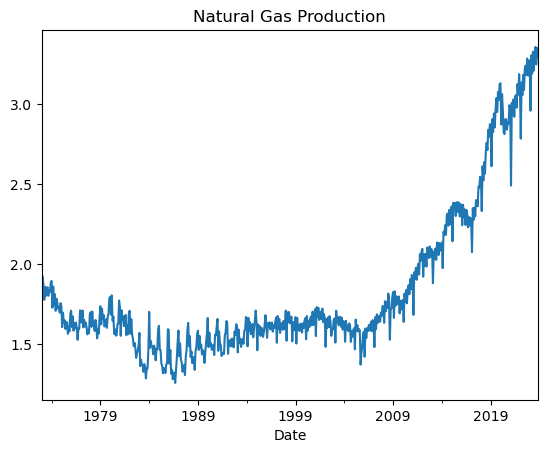

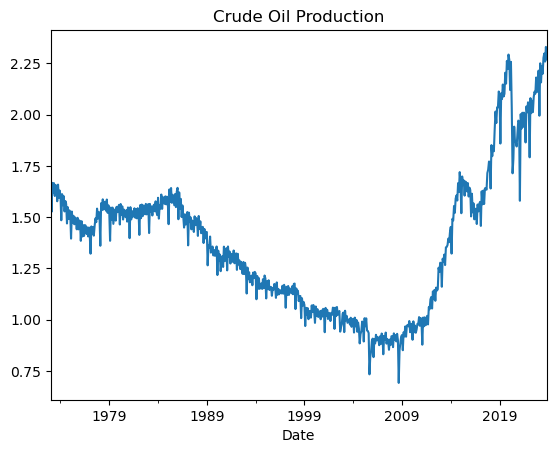

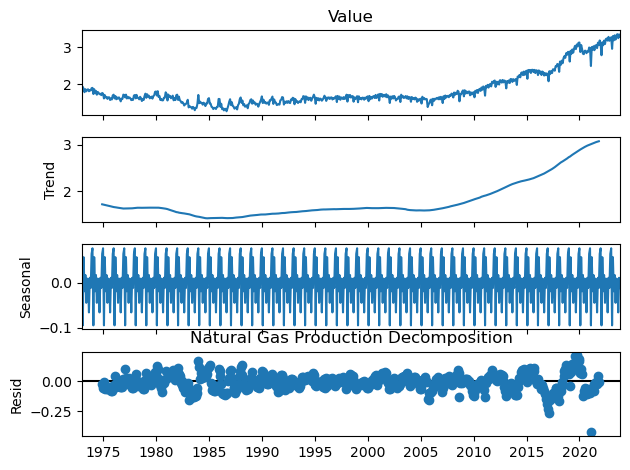

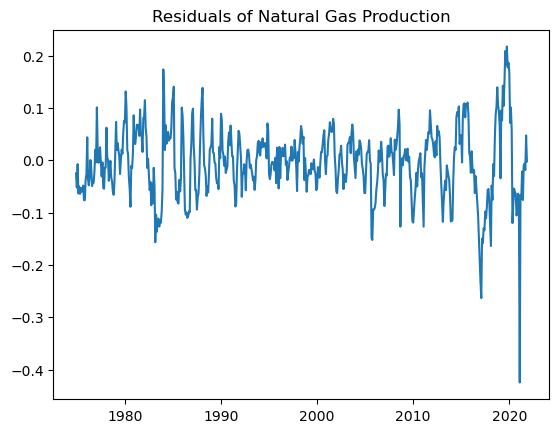

Natural Gas Production ADF Statistic: 1.5649106409464935
Natural Gas Production ADF p-value: 0.9977483916179463


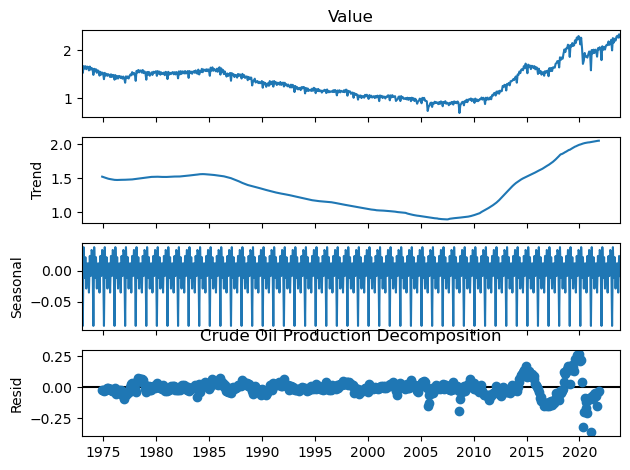

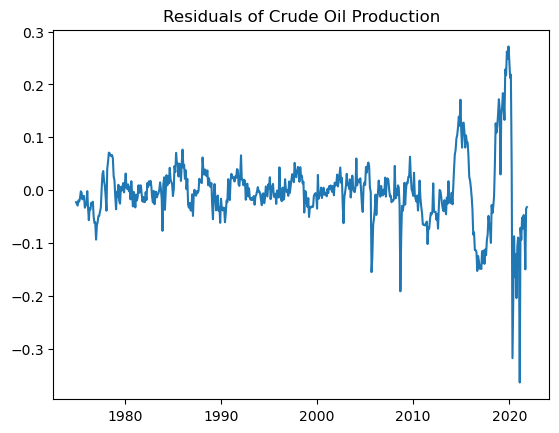

Crude Oil Production ADF Statistic: 0.05871945259778563
Crude Oil Production ADF p-value: 0.9631270108458863


In [10]:
# print dtype of each col
for col in production.columns:
    print(col, type(production[col][0]))

# Convert 'Date' to datetime
production['Date'] = pd.to_datetime(production['Date'])

# Convert 'Value' to float
# if []'Value'][0] is str, run below code:
if type(production['Value'][0]) == str:
    production['Value'] = production['Value'].apply(extract_float)

# Def series to keep (oil and gas production)
production_series_to_keep = ['Natural Gas (Dry) Production', 'Crude Oil Production',
 'Natural Gas Plant Liquids Production', 'Total Fossil Fuels Production']

# Subset production df to only keep the series we want
oil_gas_production = production[production['Description'].isin(production_series_to_keep)]

oil_gas_production['Value'].count()
oil_gas_production['Value'].isna().sum()

# print unique descriptions
print(oil_gas_production['Description'].unique())

# # print sum of 'Total Fossil Fuels Production' vs. sum of ['Natural Gas (Dry) Production', 'Crude Oil Production', 'Natural Gas Plant Liquids Production']
# print(oil_gas_production[oil_gas_production['Description'] == 'Total Fossil Fuels Production']['Value'].sum())
# print(oil_gas_production[oil_gas_production['Description'].isin(['Natural Gas (Dry) Production', 'Crude Oil Production', 'Natural Gas Plant Liquids Production'])]['Value'].sum())

# # print sum vals for the two nat gas series
# print(oil_gas_production[oil_gas_production['Description'] == 'Natural Gas (Dry) Production']['Value'].sum())
# print(oil_gas_production[oil_gas_production['Description'] == 'Natural Gas Plant Liquids Production']['Value'].sum())


# Use 'Natural Gas (Dry) Production' and 'Crude Oil Production' to represent the nat gas and crude oil production series, respectively
nat_gas_prod = oil_gas_production[oil_gas_production['Description'] == 'Natural Gas (Dry) Production']
crude_oil_prod = oil_gas_production[oil_gas_production['Description'] == 'Crude Oil Production']

nat_gas_production = nat_gas_prod['Value']
nat_gas_production.index = nat_gas_prod['Date']

crude_oil_production = crude_oil_prod['Value']
crude_oil_production.index = crude_oil_prod['Date']

# Plot both series
nat_gas_production.plot()
plt.title('Natural Gas Production')
plt.show()

crude_oil_production.plot()
plt.title('Crude Oil Production')
plt.show()

# De-Trend / De-Seasonalize Natural Gas Production
n = 48
filt = np.ones(n) / n
nat_gas_decomposition = seasonal_decompose(nat_gas_production, model='additive', filt=filt, period=12)

# plot the components
nat_gas_decomposition.plot()
plt.title('Natural Gas Production Decomposition')
plt.show()

# Plot residuals
plt.plot(nat_gas_decomposition.resid)
plt.title('Residuals of Natural Gas Production')
plt.show()

# Stationarity test
nat_gas_adf = adfuller(nat_gas_production)
print('Natural Gas Production ADF Statistic:', nat_gas_adf[0])
print('Natural Gas Production ADF p-value:', nat_gas_adf[1])

# Write to cleaned dataset:
    # natural gas production
    # trend
    # seasonal
    # residual

df = pd.DataFrame()
df['Date'] = nat_gas_production.index
df['Natural Gas Production'] = nat_gas_production.values
df['Trend'] = nat_gas_decomposition.trend.values
df['Seasonal'] = nat_gas_decomposition.seasonal.values
df['Residual'] = nat_gas_decomposition.resid.values
df.to_csv(os.path.join(write_path, 'natural_gas_production_deseasonalized.csv'), index=False)


# De-Trend / De-Seasonalize Crude Oil Production
n = 48
filt = np.ones(n) / n
crude_oil_decomposition = seasonal_decompose(crude_oil_production, model='additive', filt=filt, period=12)

# plot the components
crude_oil_decomposition.plot()
plt.title('Crude Oil Production Decomposition')
plt.show()

# Plot residuals
plt.plot(crude_oil_decomposition.resid)
plt.title('Residuals of Crude Oil Production')
plt.show()

# Stationarity test
crude_oil_adf = adfuller(crude_oil_production)
print('Crude Oil Production ADF Statistic:', crude_oil_adf[0])
print('Crude Oil Production ADF p-value:', crude_oil_adf[1])

# Write to cleaned dataset:
    # crude oil production
    # trend
    # seasonal
    # residual

df = pd.DataFrame()
df['Date'] = crude_oil_production.index
df['Crude Oil Production'] = crude_oil_production.values
df['Trend'] = crude_oil_decomposition.trend.values
df['Seasonal'] = crude_oil_decomposition.seasonal.values
df['Residual'] = crude_oil_decomposition.resid.values
df.to_csv(os.path.join(write_path, 'crude_oil_production_deseasonalized.csv'), index=False)





### EDA on Energy Stocks (Reserves)

EIA_ID <class 'str'>
YYYYMM <class 'numpy.int64'>
Date <class 'str'>
Value <class 'str'>
Column_Order <class 'numpy.int64'>
Description <class 'str'>
Unit <class 'str'>
Energy Type <class 'str'>
Energy Category <class 'str'>
Energy Class <class 'str'>
Sector <class 'float'>


C:\Users\nicho\AppData\Local\Temp\ipykernel_28104\1049311777.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_gas_stocks['Date'] = pd.to_datetime(oil_gas_stocks['Date'])
C:\Users\nicho\AppData\Local\Temp\ipykernel_28104\1049311777.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_gas_stocks['Value'] = oil_gas_stocks['Value'].apply(extract_float)


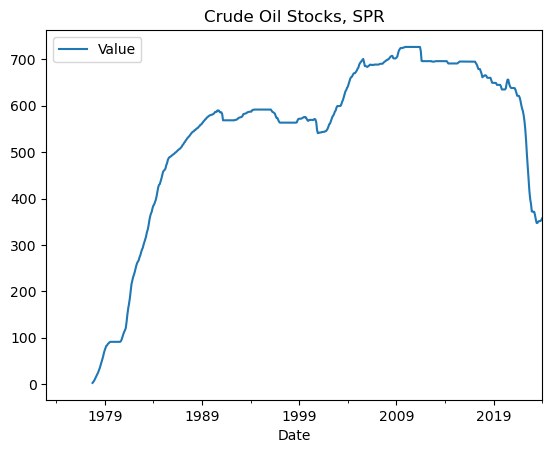

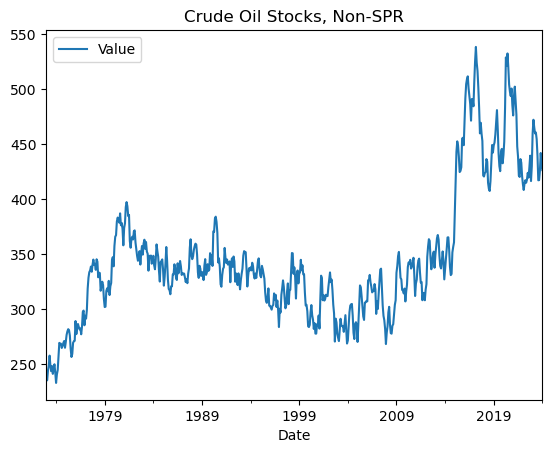

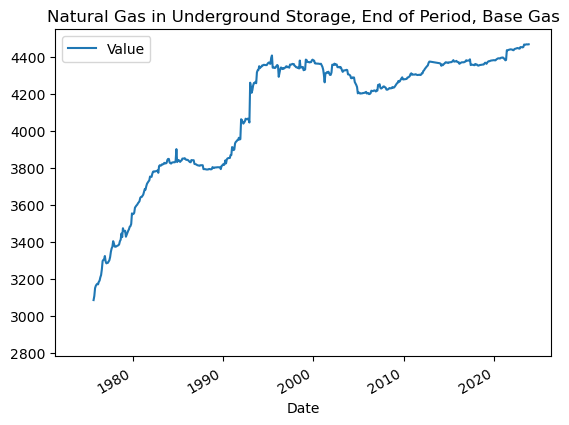

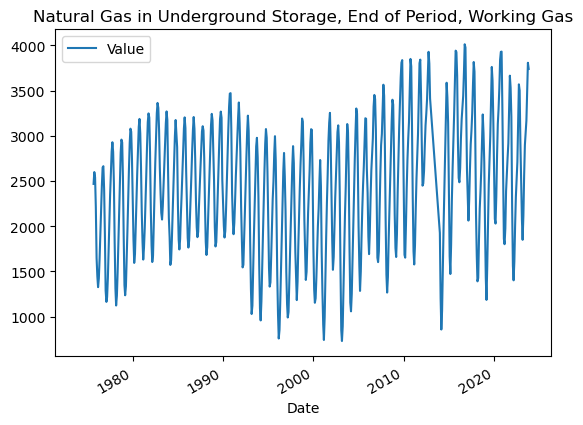

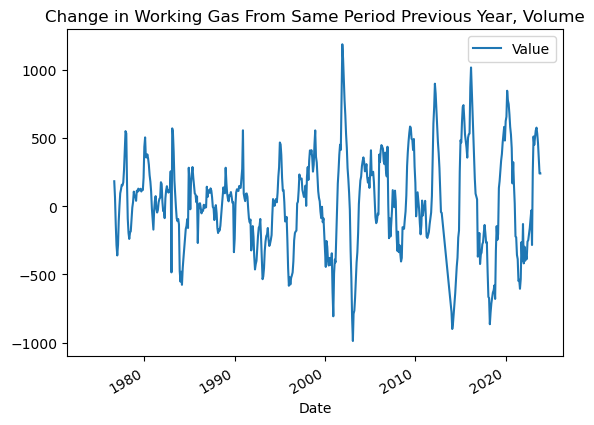

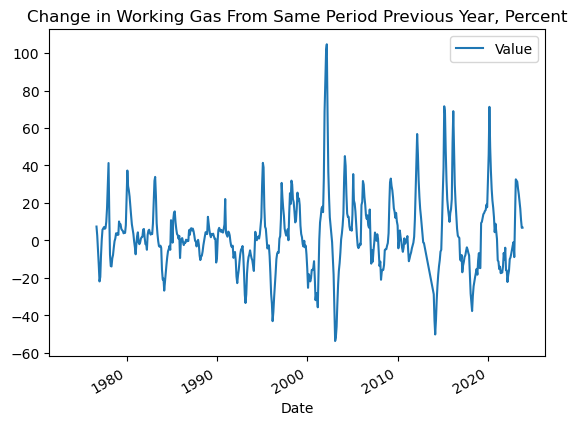

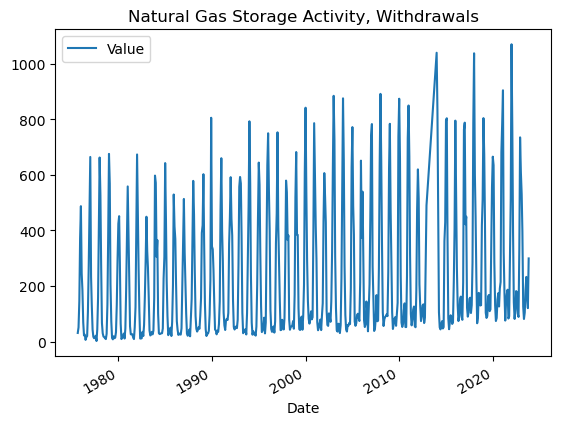

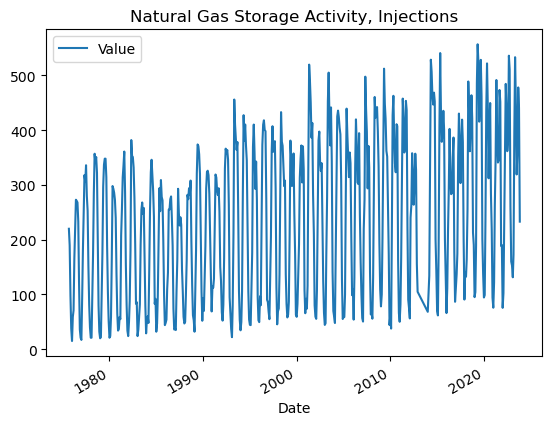

In [11]:
stocks['Energy Category'].unique()  

# Descriptions to keep
to_keep = ['Crude Oil', 'Natural Gas']

# Subset stocks df to only keep the series we want
oil_gas_stocks = stocks[stocks['Energy Category'].isin(to_keep)]

oil_gas_stocks['Description'].unique()

# Print unique units for energy category
oil_gas_stocks.groupby('Energy Category')['Unit'].unique()

# print dtype of each col in oil_gas_stocks
for col in oil_gas_stocks.columns:
    print(col, type(oil_gas_stocks[col][0]))

# Convert 'Date' to datetime
oil_gas_stocks['Date'] = pd.to_datetime(oil_gas_stocks['Date'])

# Convert 'Value' to float
# if []'Value'][0] is str, run below code:
if type(oil_gas_stocks['Value'][0]) == str:
    oil_gas_stocks['Value'] = oil_gas_stocks['Value'].apply(extract_float)

# Delete 'Sector' col
oil_gas_stocks = oil_gas_stocks.drop('Sector', axis=1)

oil_gas_stocks.dropna()

# Extract series corresponding to unique 'Description' vals

unique_descriptions = oil_gas_stocks['Description'].unique()
stocks_series_dict = {}
for description in unique_descriptions:
    stocks_series_dict[description] = oil_gas_stocks[oil_gas_stocks['Description'] == description]

# Plot each series
for key in stocks_series_dict.keys():
    stocks_series_dict[key].plot(x='Date', y='Value', title=key)
    plt.title(key)
    plt.show() 


## Market Data

### Commodity Prices and Stocks

In [13]:
futures_data_path = r"data\\!new_datasets\\refinitiv_futures_data"

market_data_folderpath = r"data\!Spring_Invitational_2024_data\Datathon_Data"


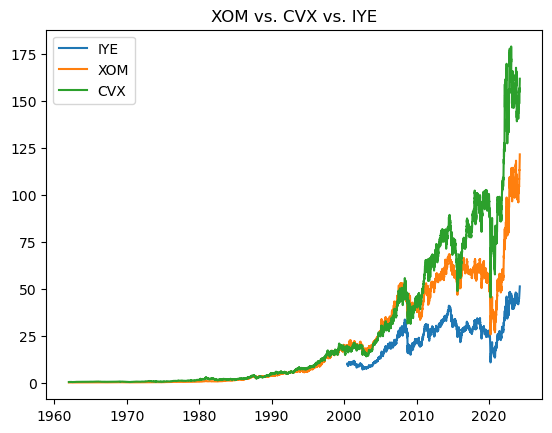

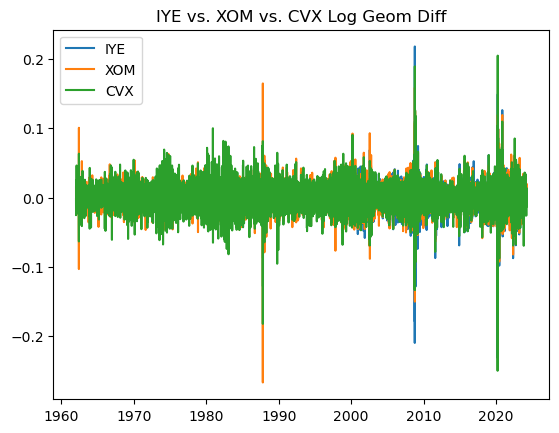

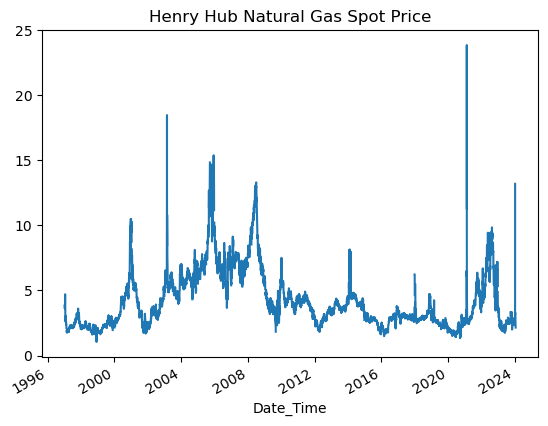

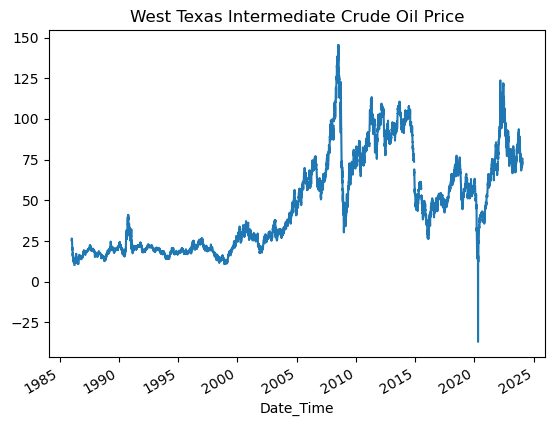

c:\Users\nicho\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


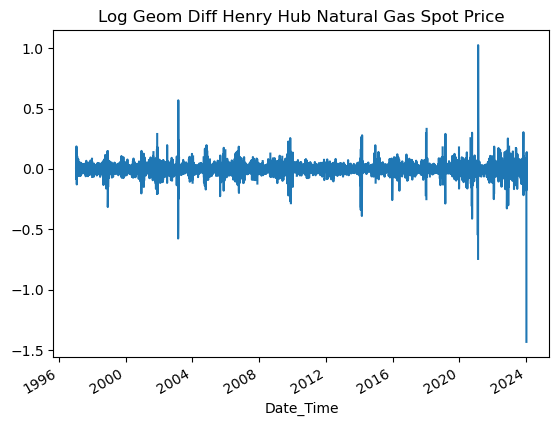

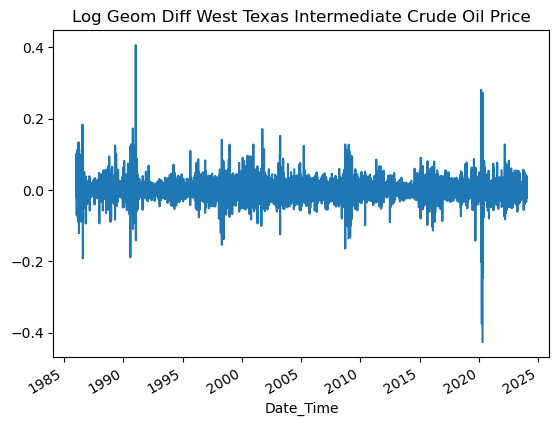

262 0.03710522588868432
343 0.034548751007252215
491 0.06954674220963172
663 0.066787549108492


In [14]:
# Define paths### Commodity Prices and Stock Market
all_commodities = pd.read_csv(os.path.join(market_data_folderpath, 'all_commodities.csv'))

all_stocks = pd.read_csv(os.path.join(market_data_folderpath, 'all_stocks_and_etfs.csv'))

stock_descriptions = pd.read_csv(os.path.join(market_data_folderpath, 'stock_descriptions.csv'))
### EDA on Commodity and Stock Prices
spy_price = all_stocks[all_stocks['Ticker_Symbol'] == 'SPY']['Close']
spy_price.index = all_stocks[all_stocks['Ticker_Symbol'] == 'SPY']['Date-Time']
# Stock Market Data

all_stocks

stock_descriptions



# Create a dict of dfs for each stock, indexed by 'Symbol'. Save all rows with 'Symbol' == symbol to the df
# Only if AssetType is Common Stock

common_stock_symbols = stock_descriptions[stock_descriptions['AssetType'] == 'Common Stock']['Symbol'].unique()
common_stock_dict = {}
for symbol in common_stock_symbols:
    common_stock_dict[symbol] = all_stocks[all_stocks['Ticker_Symbol'] == symbol]


etf_symbols = stock_descriptions[stock_descriptions['AssetType'] == 'ETF']['Symbol'].unique()
etf_dict = {}
for symbol in etf_symbols:
    etf_dict[symbol] = all_stocks[all_stocks['Ticker_Symbol'] == symbol]


# Validate the dict structure and endpoint dfs
etf_dict[list(etf_dict.keys())[3]]

common_stock_dict[list(common_stock_dict.keys())[5]]


# Pull IYE - iShares U.S. Energy ETF data from yfinance
import yfinance as yf

# pull data for IYE
iye = yf.Ticker('IYE')
iye_data = iye.history(period='max')


# Plot the closing price of IYE
plt.plot(iye_data['Close'])

# Get Exxon Mobil stock data and Chevron stock data and overlay the closing prices
xom = yf.Ticker('XOM')
xom_data = xom.history(period='max')

cvx = yf.Ticker('CVX')
cvx_data = cvx.history(period='max')

plt.plot(xom_data['Close'])
plt.plot(cvx_data['Close'])
plt.title('XOM vs. CVX vs. IYE')
plt.legend(['IYE', 'XOM', 'CVX'])
plt.show()


# Overlay log geom diff plots for all 3
iye_log_geom_diff = np.log(iye_data['Close']) - np.log(iye_data['Close'].shift(1))
xom_log_geom_diff = np.log(xom_data['Close']) - np.log(xom_data['Close'].shift(1))
cvx_log_geom_diff = np.log(cvx_data['Close']) - np.log(cvx_data['Close'].shift(1))

plt.plot(iye_log_geom_diff)
plt.plot(xom_log_geom_diff)
plt.plot(cvx_log_geom_diff)
plt.title('IYE vs. XOM vs. CVX Log Geom Diff')
plt.legend(['IYE', 'XOM', 'CVX'])
plt.show()


# Create log_geom_diff for spy
spy_log_geom_diff = np.log(spy_price) - np.log(spy_price.shift(1))

#Drop NaN in log_geom_diffs
iye_log_geom_diff = iye_log_geom_diff[1:]
spy_log_geom_diff = spy_log_geom_diff[1:]

# Save S&P 500 data to cleaned data prices folder along with IYE
iye_data.to_csv(os.path.join(write_path, 'IYE.csv'))
spy_price.to_csv(os.path.join(write_path, 'SPY.csv'))
# Save log geom diffs
iye_log_geom_diff.to_csv(os.path.join(write_path, 'IYE_log_geom_diff.csv'))
spy_log_geom_diff.to_csv(os.path.join(write_path, 'SPY_log_geom_diff.csv'))



all_commodities['Commodity'].unique()

# Keep only 'Henry Hub Natural Gas Spot Price' and  'West Texas Intermediary Crude Oil'
hh_nat_gas = all_commodities[all_commodities['Commodity'] == 'Henry Hub Natural Gas Spot Price']
wti = all_commodities[all_commodities['Commodity'] == 'West Texas Intermediary Crude Oil']


henry_hub_ng_price = hh_nat_gas['Value']
henry_hub_ng_price.index = hh_nat_gas['Date_Time']
# set to datetime
henry_hub_ng_price.index = pd.to_datetime(henry_hub_ng_price.index)

west_texas_intermediate_price = wti['Value']
west_texas_intermediate_price.index = wti['Date_Time']
# set to datetime
west_texas_intermediate_price.index = pd.to_datetime(west_texas_intermediate_price.index)

# Plot both series
henry_hub_ng_price.plot()
plt.title('Henry Hub Natural Gas Spot Price')
plt.show()

west_texas_intermediate_price.plot()
plt.title('West Texas Intermediate Crude Oil Price')
plt.show()


# Take the log geom diff in price for both series
log_geom_diff_henry_hub_ng_price = np.log(henry_hub_ng_price / henry_hub_ng_price.shift(1))
log_geom_diff_henry_hub_ng_price = log_geom_diff_henry_hub_ng_price[1:]

log_geom_diff_west_texas_intermediate_price = np.log(west_texas_intermediate_price / west_texas_intermediate_price.shift(1))
log_geom_diff_west_texas_intermediate_price = log_geom_diff_west_texas_intermediate_price[1:]

# Plot both series
log_geom_diff_henry_hub_ng_price.plot()
plt.title('Log Geom Diff Henry Hub Natural Gas Spot Price')
plt.show()

log_geom_diff_west_texas_intermediate_price.plot()
plt.title('Log Geom Diff West Texas Intermediate Crude Oil Price')
plt.show()

# Create dir to store cleaned price data
if not os.path.exists("data\cleaned_data\prices"):
    os.makedirs("data\cleaned_data\prices")

write_path = "data\cleaned_data\prices" 

# Write to cleaned dataset:
    # henry hub natural gas price
    # west texas intermediate crude oil price
    # log geom diff henry hub natural gas price
    # log geom diff west texas intermediate crude oil price


# print # NaN in each series and the ratio of NaN to total rows
print(henry_hub_ng_price.isna().sum(), henry_hub_ng_price.isna().sum() / len(henry_hub_ng_price))
print(west_texas_intermediate_price.isna().sum(), west_texas_intermediate_price.isna().sum() / len(west_texas_intermediate_price))
print(log_geom_diff_henry_hub_ng_price.isna().sum(), log_geom_diff_henry_hub_ng_price.isna().sum() / len(log_geom_diff_henry_hub_ng_price))
print(log_geom_diff_west_texas_intermediate_price.isna().sum(), log_geom_diff_west_texas_intermediate_price.isna().sum() / len(log_geom_diff_west_texas_intermediate_price))

# Drop NaNs
henry_hub_ng_price = henry_hub_ng_price.dropna()
west_texas_intermediate_price = west_texas_intermediate_price.dropna()
log_geom_diff_henry_hub_ng_price = log_geom_diff_henry_hub_ng_price.dropna()
log_geom_diff_west_texas_intermediate_price = log_geom_diff_west_texas_intermediate_price.dropna()

# Store each as a separate csv
df = pd.DataFrame()
df.index = henry_hub_ng_price.index
df['Henry Hub Natural Gas Spot Price'] = henry_hub_ng_price.values
df.to_csv(os.path.join(write_path, 'henry_hub_ng_price.csv'), index=True)

df = pd.DataFrame()
df.index = west_texas_intermediate_price.index
df['WTI Crude Oil Price'] = west_texas_intermediate_price.values
df.to_csv(os.path.join(write_path, 'wti_price.csv'), index=True)

df = pd.DataFrame()
df.index = log_geom_diff_henry_hub_ng_price.index
df['Log Geom Diff Henry Hub Natural Gas Spot Price'] = log_geom_diff_henry_hub_ng_price.values
df.to_csv(os.path.join(write_path, 'log_geom_diff_henry_hub_ng_price.csv'), index=True)

df = pd.DataFrame()
df.index = log_geom_diff_west_texas_intermediate_price.index
df['Log Geom Diff WTI Crude Oil Price'] = log_geom_diff_west_texas_intermediate_price.values
df.to_csv(os.path.join(write_path, 'log_geom_diff_wti_price.csv'), index=True)


### Futures Curves

In [15]:

wti_futures_curve = pd.read_csv(os.path.join(futures_data_path, 'wti_futures_curve_clean.csv'))

hh_nat_gas_futures_curve = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_futures_curve.csv'))



In [16]:
# Import and configure data
wti_spot = pd.read_csv("data\cleaned_data\prices\wti_price.csv")
hh_nat_gas_spot = pd.read_csv("data\cleaned_data\prices\henry_hub_ng_price.csv")

wti_futures_curve.index = pd.to_datetime(wti_futures_curve['datetime_index'])
hh_nat_gas_futures_curve.index = pd.to_datetime(hh_nat_gas_futures_curve['datetime_index'])

wti_spot.index = pd.to_datetime(wti_spot['Date_Time'])
hh_nat_gas_spot.index = pd.to_datetime(hh_nat_gas_spot['Date_Time'])

# Remove datetime indices from all of the above
wti_futures_curve = wti_futures_curve.drop('datetime_index', axis=1)
hh_nat_gas_futures_curve = hh_nat_gas_futures_curve.drop('datetime_index', axis=1)
wti_spot = wti_spot.drop('Date_Time', axis=1)
hh_nat_gas_spot = hh_nat_gas_spot.drop('Date_Time', axis=1)



In [17]:
# check index type of wti_spot and wti_futures_curve
print(wti_spot.index.dtype, wti_futures_curve.index.dtype)

# count the num of aligned indices as a % of total indices in each df

def count_aligned_indices(df1, df2):
    num_aligned_indices = df1.index.isin(df2.index).sum()
    total_indices = len(df1.index)
    aligned_pct_1_in_2 = num_aligned_indices / total_indices

    num_aligned_indices = df2.index.isin(df1.index).sum()
    total_indices = len(df2.index)
    aligned_pct_2_in_1 = num_aligned_indices / total_indices

    return aligned_pct_1_in_2, aligned_pct_2_in_1

# Print outputs for wti_spot and wti_futures_curve as well as hh_nat_gas_spot and hh_nat_gas_futures_curve
print(count_aligned_indices(wti_spot, wti_futures_curve))
print(count_aligned_indices(hh_nat_gas_spot, hh_nat_gas_futures_curve))



datetime64[ns] datetime64[ns]
(0.4229525299947835, 0.9505275498241501)
(0.999264597734961, 0.8899659418391407)


In [18]:
wti_spot.iloc[:,0]

Date_Time
2024-01-22    75.26
2024-01-19    73.69
2024-01-18    74.32
2024-01-17    72.79
2024-01-16    72.63
              ...  
1986-01-08    25.87
1986-01-07    25.85
1986-01-06    26.53
1986-01-03    26.00
1986-01-02    25.56
Name: WTI Crude Oil Price, Length: 9585, dtype: float64

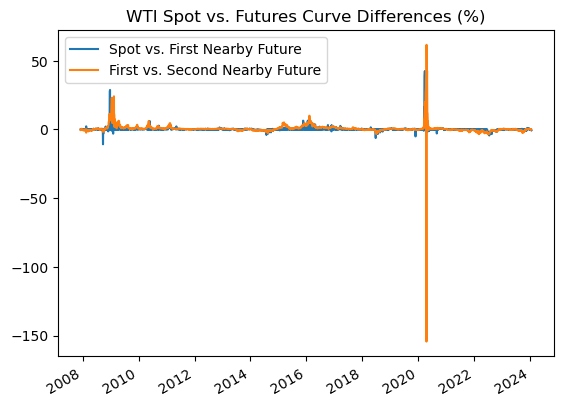

       spot_first_diff  first_second_diff
count      4054.000000        4054.000000
mean          0.150362           0.692079
std           1.654792           3.764318
min         -10.798467        -154.291788
25%          -0.045139          -0.196709
50%           0.014815           0.348573
75%           0.135253           0.828867
max          42.482270          61.538462


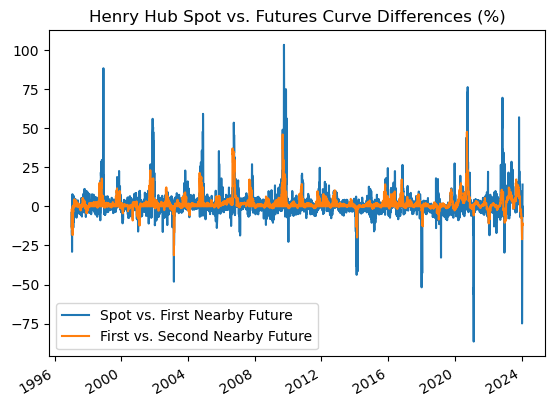

       spot_first_diff  first_second_diff
count      6794.000000        6794.000000
mean          1.697180           2.238004
std           7.785622           4.663220
min         -86.508801         -31.251958
25%          -1.536544           0.076174
50%           0.643135           1.251977
75%           3.418533           3.002915
max         103.362069          47.683924


,contract1,contract2,contract3,contract4,contract5,contract6,contract7,contract8,contract9
datetime_index,,,,,,,,,
1995-01-03,1.683,1.681,1.644,1.644,1.659,1.673,1.686,1.698,1.756
1995-01-04,1.617,1.619,1.609,1.614,1.629,1.644,1.659,1.669,1.727
1995-01-05,1.552,1.574,1.574,1.584,1.602,1.621,1.637,1.649,1.709
1995-01-06,1.499,1.531,1.533,1.543,1.563,1.583,1.601,1.616,1.676
1995-01-09,1.454,1.482,1.494,1.507,1.530,1.558,1.578,1.597,1.660
...,...,...,...,...,...,...,...,...,...
2024-04-01,1.837,2.074,2.405,2.511,2.507,2.599,2.997,3.506,3.790
2024-04-02,1.862,2.105,2.430,2.540,2.532,2.619,3.009,3.511,3.787
2024-04-03,1.841,2.067,2.386,2.494,2.487,2.573,2.963,3.471,3.745


In [19]:
# Check that spot prices are aligned with futures curves
# For each date, pull the first nearby future (col 0) and save the % difference between it and spot price, as well as the % difference between the first nearby future and the second nearby future (col 1)


import pandas as pd
import numpy as np

# Assuming wti_spot and wti_futures_curve are defined, with proper datetime indexes
# Align indices
aligned_idx_wti = wti_futures_curve.index.intersection(wti_spot.index)

# Create DataFrame for differences
df_wti = pd.DataFrame(index=aligned_idx_wti)
df_wti['spot_first_diff'] = (wti_futures_curve.loc[aligned_idx_wti, 'contract1'] / wti_spot.loc[aligned_idx_wti].iloc[:,0] - 1) * 100
df_wti['first_second_diff'] = (wti_futures_curve.loc[aligned_idx_wti, 'contract2'] / wti_futures_curve.loc[aligned_idx_wti, 'contract1'] - 1) * 100


# plot both columns over time
df_wti.plot()
plt.title('WTI Spot vs. Futures Curve Differences (%)')
plt.legend(['Spot vs. First Nearby Future', 'First vs. Second Nearby Future'])
plt.show()

# Print the means and std of both
print(df_wti.describe())

# Create new df with the same structure as df, but for hh_nat_gas
hh_nat_gas_spot = hh_nat_gas_spot.dropna()
hh_nat_gas_futures_curve = hh_nat_gas_futures_curve.dropna()
# rename cols of hh_nat_gas_futures_curve as 'contract1', 'contract2', 'contract3', etc.
hh_nat_gas_futures_curve.columns = ['contract1', 'contract2', 'contract3', 'contract4', 'contract5', 'contract6', 'contract7', 'contract8', 'contract9']

aligned_idx_hh = hh_nat_gas_futures_curve.index.intersection(hh_nat_gas_spot.index)

df_hh = pd.DataFrame(index=aligned_idx_hh)
df_hh['spot_first_diff'] = (hh_nat_gas_futures_curve.loc[aligned_idx_hh, 'contract1'] / hh_nat_gas_spot.loc[aligned_idx_hh].iloc[:,0] - 1) * 100
df_hh['first_second_diff'] = (hh_nat_gas_futures_curve.loc[aligned_idx_hh, 'contract2'] / hh_nat_gas_futures_curve.loc[aligned_idx_hh, 'contract1'] - 1) * 100

df_hh.plot()
plt.title('Henry Hub Spot vs. Futures Curve Differences (%)')
plt.legend(['Spot vs. First Nearby Future', 'First vs. Second Nearby Future'])
plt.show()

print(df_hh.describe())

hh_nat_gas_futures_curve


In [20]:
# For both hh and wti, create new dfs with only the aligned indices. Then, add the underlying spot price to each df as the 0th col.

#wti:

wti_spot = wti_spot.dropna()
wti_futures_curve = wti_futures_curve.dropna()

aligned_idx_wti = wti_futures_curve.index.intersection(wti_spot.index)

wti_spot = wti_spot.loc[aligned_idx_wti]
wti_futures_curve = wti_futures_curve.loc[aligned_idx_wti]

wti_futures_curve.insert(0, 'spot', wti_spot.iloc[:,0])

#hh:

hh_nat_gas_spot = hh_nat_gas_spot.dropna()
hh_nat_gas_futures_curve = hh_nat_gas_futures_curve.dropna()

aligned_idx_hh = hh_nat_gas_futures_curve.index.intersection(hh_nat_gas_spot.index)

hh_nat_gas_spot = hh_nat_gas_spot.loc[aligned_idx_hh]
hh_nat_gas_futures_curve = hh_nat_gas_futures_curve.loc[aligned_idx_hh]

hh_nat_gas_futures_curve.insert(0, 'spot', hh_nat_gas_spot.iloc[:,0])



In [21]:
# For each df, calculate the % difference between the spot price and each future contract price and save as a new df

#wti:
wti_diffs = wti_futures_curve.copy()
for col in wti_diffs.columns[1:]:
    wti_diffs[col] = (wti_futures_curve['spot'] / wti_futures_curve[col]) - 1
#hh:
hh_diffs = hh_nat_gas_futures_curve.copy()
for col in hh_diffs.columns[1:]:
    hh_diffs[col] = (hh_nat_gas_futures_curve['spot'] / hh_nat_gas_futures_curve[col]) - 1

# Add "% diff from spot" to all cols from indices 1:end
str = " % diff from spot"
wti_diffs.columns = ['spot'] + [col + str for col in wti_diffs.columns[1:]]
hh_diffs.columns = ['spot'] + [col + str for col in hh_diffs.columns[1:]]

wti_diffs
hh_diffs

,spot,contract1 % diff from spot,contract2 % diff from spot,contract3 % diff from spot,contract4 % diff from spot,contract5 % diff from spot,contract6 % diff from spot,contract7 % diff from spot,contract8 % diff from spot,contract9 % diff from spot
1997-01-07,3.82,0.145771,0.171779,0.488698,0.649396,0.713773,0.721496,0.723827,0.721496,0.717626
1997-01-08,3.80,0.081697,0.196474,0.426962,0.620469,0.692650,0.707865,0.711712,0.711712,0.707865
1997-01-09,3.61,0.037058,0.169799,0.384202,0.558722,0.624662,0.640909,0.648402,0.648402,0.644647
1997-01-10,3.92,0.182147,0.375921,0.594793,0.742222,0.789954,0.806452,0.810624,0.810624,0.806452
1997-01-13,4.00,0.229256,0.398601,0.630656,0.775411,0.830664,0.847575,0.851852,0.851852,0.847575
...,...,...,...,...,...,...,...,...,...,...
2024-01-17,2.86,-0.003484,0.145833,0.155556,0.128650,0.073171,0.020335,0.004566,0.011673,-0.013453
2024-01-18,2.88,0.067853,0.193535,0.196510,0.161759,0.102181,0.046512,0.029307,0.036717,0.009110
2024-01-19,2.70,0.071854,0.198934,0.191001,0.147471,0.081731,0.021180,0.001484,0.008592,-0.019608
2024-01-22,2.35,-0.028524,0.105882,0.096082,0.050514,-0.015501,-0.074074,-0.093714,-0.088441,-0.117205


### Futures Options (1 month until expiry on front month contract) and Volume

In [22]:
wti_options_deltas = pd.read_csv(os.path.join(futures_data_path, 'wti_continuous_options_deltas.csv'))

wti_options_moneyness = pd.read_csv(os.path.join(futures_data_path, 'wti_continuous_options_moneyness.csv'))

hh_nat_gas_options_deltas = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_continuous_options_deltas.csv'))

hh_nat_gas_options_moneyness = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_continuous_options_moneyness.csv'))

wti_futures_volume = pd.read_csv(os.path.join(futures_data_path, 'wti_futures_continuous_volume.csv'))

hh_nat_gas_futures_volume = pd.read_csv(os.path.join(futures_data_path, 'hh_nat_gas_futures_volume_.csv'))

wti_options_moneyness.set_index('datetime_index', inplace=True)
wti_options_deltas.set_index('datetime_index', inplace=True)

hh_nat_gas_options_moneyness.set_index('datetime_index', inplace=True)
hh_nat_gas_options_deltas.set_index('datetime_index', inplace=True)

### Write WTI Futures to CSV

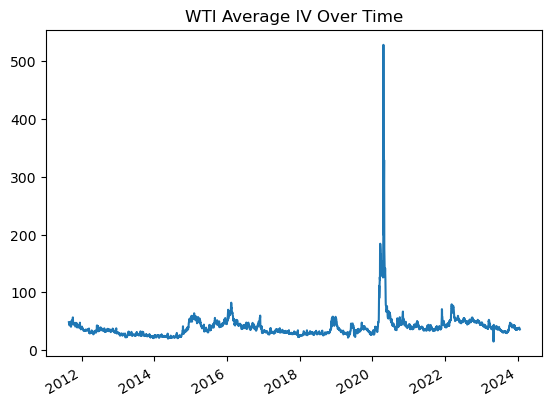

In [23]:
# Plot the IVs at different moneyness for wti for a given date

idx_list = np.linspace(0, len(wti_options_moneyness.index) - 1, 10, dtype=int)
date_list = wti_options_deltas.index[idx_list]

# # plot columns at the given date
# for date in date_list:
#     wti_options_moneyness.loc[date].plot()
#     plt.title('WTI IVs by Moneyness at ' + date)
#     plt.show()

# Obtain a series where the index is the date and the value is the average IV for all moneyness levels for each date
# Only subset for dates in wti_aligned_idx

# convert the index to datetime
wti_options_moneyness.index = pd.to_datetime(wti_options_moneyness.index)
wti_aligned_idx = wti_diffs.index.intersection(wti_options_moneyness.index)
wti_avg_iv = wti_options_moneyness.loc[wti_aligned_idx].mean(axis=1)

# Plot the average IVs over time
wti_avg_iv.plot()
plt.title('WTI Average IV Over Time')
plt.show()

# create new df which is copy of wti_diffs, but with the average IV series added as a new col (col 0)
wti_futures_diffs = wti_diffs.copy()
wti_futures_diffs.insert(0, 'avg_iv', wti_avg_iv)

wti_futures_diffs

# Write to CSV
    # new folder for futures data
if not os.path.exists("data\\cleaned_data\\futures"):
    os.makedirs("data\\cleaned_data\\futures")

write_path = "data\\cleaned_data\\futures"

wti_futures_diffs.to_csv(os.path.join(write_path, 'wti_futures_diffs.csv'))




# SVAR Model

** Model Specification **

$$
A_0 Y_t = A_1 Y_{t-1} + ... + A_p Y_{t-p} + B \varepsilon_t
$$

Where:
- $Y_t$: Vector of endogenous variables at time $t$.
- $A_0, A_1, ..., A_p$: Matrices of coefficients capturing the contemporaneous and lagged relationships among the variables.
- $\varepsilon_t$: Vector of structural shocks.
- $B$: Matrix mapping structural shocks to the endogenous variables, incorporating theoretical restrictions.

** Estimation Procedure **

1. **Estimate Reduced-Form VAR**: Fit a Vector Autoregression model to the data without structural restrictions to obtain reduced-form coefficients and residuals.

2. **Impose Structural Restrictions**: Based on economic theory, apply restrictions to the matrices $A_0$ and $B$ to identify the structural shocks.

3. **Recover Structural Shocks**: Utilize the estimated VAR coefficients and imposed restrictions to derive the structural shocks ($\varepsilon_t$) and matrices $A_0$ and $B$.

4. **IRFs and Variance Decomposition**: Examine impulse response functions and forecast error variance decompositions to assess the effects of structural shocks.


In [24]:
# 